
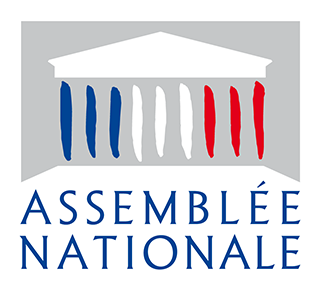

## RAMP on french deputies votes prediction

Team members: *Florian Eisenbarth, Nicolas Oulianov, Nicolas Boussenina, Armand Foucault, Eloi Alardet*


## Introduction

This group project is about predicting positions of deputies on votes in the French National Assembly. 

### Context

#### The National Assembly

We will be studying votes in the French National Assembly. 

The National Assembly is the French lower house of the parliament, the higher house being the Senate. The Assembly is composed of deputies elected every five years during legislatives elections. One deputy represents one electoral district, composed of 63 000 to 150 000 inhabitants. In total, there are 577 seats available for the deputies in the Assembly. 

Most of the times, deputies campaign in their district under the banner of a **political party**. But once elected, inside the Assembly, deputies join or create **parliamentary groups** of at least 15 deputies, that are not exactly the same as political parties.

These groups are used for various reasons.

- Small parties can group their voting forces.
- Likely-minded deputies that are not in the same political parties can work together.
- You get various advantages: more time to talk at the Assembly and one representative at the President's conference (a weekly reunion of all the parliamentary groups presidents).

Some groups corresponds to exactly one party. For example, the group "En marche" or the group "Les Républicains". But this is far from the case of every group. 

If a deputy does not belong to any parliamentary groups, he is part of the **‘non inscrit’** group, which is not a parliamentary group strictly speaking.

A deputy can also be a member of a **parliamentary commission**, which are specialized groups that review the laws for a specific subject (finance, security, health…). 

How these groups vote is the focus of this project. 


#### What do we vote in the Assembly ?

In the French legislative system, the government and deputies propose laws. Before a law is adopted, the text is called a: 

+ **project of law**, when it is proposed by the government
+ **proposition of law**, when it is proposed by a parliament member

Please note that that those are literal French translations, as we are not legalists. 

All members of the parliament, commissions and the government can propose **amendments** which are modifications about parts or articles of the discussed text of law. We call those who propose amendments (or any kind of vote) **demandeurs** (literally *askers*), and we will refer to them as **demandeur groups**. The groups that vote on these amendments will be refered as **voting groups**. 

An amendment is basically a rewrite of one particular aspect of the text of law. There also exists **sub-amendments**, which are amendments of an amendment. Even a small amendment, that adds a comma in a text, is important. Everything that is voted ultimately becomes law and is enforced.  

All text of laws and amendments are voted by absolute majority, where one deputy equals one vote. However, for most of the votes, you don't need every deputy to be present to vote. 

Given a vote topic, we will try to predict the position of each group on this topic.  

### Objective

Citizens scrutinize the deputies they voted for with great interest. A concern is that deputies don't vote thinking about the vote topic itself, but only with partisanship reasoning: they vote for an allied political group, and against an ennemy political group. These "friendship rules" undermine Democracy and are disapproved by citizens. Indeed, it's seen more as a political warfare than a democratic co-construction of the French society. 

Our goal is to study to which extent political groups' votes in the Assembly are reducible to those "friendship rules", and are thus predictible. In other words, **our project is a [Multilabel classification task](https://scikit-learn.org/stable/modules/multiclass.html) to predict if a set of parliamentary group vote for a given vote topic, or not.**

Note that to simplify the problem, we reduce the number of positions to two (**for** or **not for**). But in reality, there can be 4 possible positions: for, against, abstention, or non-presence. We also don't consider every parliamentary group for prediction, but only the largest ones. 

**The metric used for evaluation is a weighted F1-score:** several F1-scores are computed for each class (parliamentary group), and then averaged, using the logarithm of the share of deputies in Assembly for this parliamentary group as weights. 

### Data

Most of the data we use in this project comes from government's [open data, freely available on the National Assembly website](https://data.assemblee-nationale.fr/). Some additional features were created using aggregated data from [nosdeputes.fr](https://www.nosdeputes.fr/). 

Data from the government is very large, as everything ever said or proposed is recorded, and not in the format we want. We will describe below the processing we performed. 

#### Processing

1. We gather the various stacks of individual .csv files into aggregate ones with only relevant information. We create aggregate .csv :
    - one .csv with all the **actors**, which is another name for deputies and scenators. 
    - one .csv with all information about **votes** : topic, date...
    - one .csv with the **results of votes** 
2. We filter these aggregate .csv to keep only relevant information. We keep only data relevant to the latest election. In otherwords, we select data in the timeframe between July, 4th 2017 and November, 20th 2020. 
3. We format this data in a "prediction-ready" format, with a features DataFrame X and a target np.array y. 

#### Description

Here are the **features** we made available for the problem:
+ **vote_uid (str)**: the id of the vote
+ **date (str)**: date of the vote
+ **libelle (str)**: short description of the topic of the vote
+ **code_type_vote (str)**: code of the type of the vote
+ **libelle_type_vote (str)**: same as code_type_vote but more explicit
+ **demandeur (str)** : the deputy or group which has asked for this vote
+ **presence_per_party (dict)**: number of deputies physically present for the vote by group
 
Our **target** corresponds to the results of the vote. 
- There are 10 columns, one for each parliamentary group considered. 
- Each line corresponds to a vote. The index is the vote_id. 
- The values are 1 if the group voted for, 0 if the group did something else (*against, abstention, non-presence*) 

We also provided another .csv file with information about political parties and their members : birth date, sex, twitter... This .csv can be used for further feature engineering. 

#### Train-test split

The train-test split is made temporally. First 80% of votes are in the train dataset, last 20% of votes are in the test dataset. This is because votes are temporally bounded and, ultimately, we want to predict future political decisions.

### Data Exploration

To better understand the problem, let's drill down in the data.

In [1]:
from problem import get_train_data, get_test_data, get_actor_party_data
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

X = X_train.append(X_test)
y = np.concatenate([y_train, y_test])

actors = get_actor_party_data()

In [2]:
# X the features vectors with info about votes

X.head(5)

,code_type_vote,libelle_type_vote,demandeur,libelle,nb_votants,date,presence_per_party,vote_uid
VTANR5L15V1,SPS,scrutin public solennel,Conference des Presidents,la declaration de politique generale du Gouver...,566,2017-07-04,"{'SOC': 22, 'FI': 17, 'Dem': 51, 'LT': 17, 'GD...",VTANR5L15V1
VTANR5L15V2,SPO,scrutin public ordinaire,"President(e) du groupe ""La Republique en Marche""",l'ensemble du projet de loi prorogeant l'appli...,150,2017-07-06,"{'SOC': 3, 'FI': 11, 'Dem': 9, 'LT': 1, 'GDR':...",VTANR5L15V2
VTANR5L15V3,SPO,scrutin public ordinaire,"President du groupe ""Nouvelle Gauche""",la motion de renvoi en commission deposee par ...,225,2017-07-10,"{'SOC': 4, 'FI': 15, 'Dem': 15, 'LT': 4, 'GDR'...",VTANR5L15V3
VTANR5L15V4,SPO,scrutin public ordinaire,"President(e) du groupe ""de la Gauche democrate...",l'amendement n? 13 de M. Gilbert Collard et le...,202,2017-07-10,"{'SOC': 0, 'FI': 15, 'Dem': 11, 'LT': 4, 'GDR'...",VTANR5L15V4
VTANR5L15V5,SPO,scrutin public ordinaire,"Président du groupe ""Nouvelle Gauche""",l'amendement n° 132 de M. Prud'homme et les am...,182,2017-07-10,"{'SOC': 4, 'FI': 14, 'Dem': 9, 'LT': 2, 'GDR':...",VTANR5L15V5


In [3]:
X['libelle'].iloc[10] # Example of the libelle of a vote

"l'amendement n° 118 de M. Quatennens et les amendements identiques suivants à l'article premier du projet de loi d'habilitation à prendre par ordonnances les mesures pour le renforcement du dialogue social (première lecture)."

In [4]:
# y the mutlilabel target vector
# To each of the 10 columns corresponds a political group, as defined in Context:
y_columns = ["SOC", "FI", "Dem", "LT", "GDR", "LaREM", "Agir ens", "UDI-I", "LR", "NI"]

# Those corresponds to :
# Socialistes et apparentés, France insoumise, Mouvement démocrate et indépendant,
# Libertés et Territoires, Gauche Démocratique et République, La République En Marche,
# Agir Ensemble, UDI et Indépendants, Les Républicains, Non inscrits

# It's an numpy array, but we convert it into a dataframe for easier manipulation.
y = pd.DataFrame(y, columns=y_columns)
y.index = X.index
y.head(5)

,SOC,FI,Dem,LT,GDR,LaREM,Agir ens,UDI-I,LR,NI
VTANR5L15V1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
VTANR5L15V2,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
VTANR5L15V3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
VTANR5L15V4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
VTANR5L15V5,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# actors is data to be used for feature engineering
# It was downloaded from mesdeputes.fr 
# It can give good insight about who's inside the parliament and who they are. 

actors.head(8)

,Unnamed: 0,membre_acteurRef,membre_civ,membre_prenom,membre_nom,slug,custom_id,membre_fullname,membre_birthDate,membre_sex,membre_parti
0,0,PA719108,M.,Raphaël,Gérard,raphael gerard,313,Raphaël Gérard,1968-10-17,H,La République en Marche
1,0,PA719044,Mme,Nadia,Essayan,nadia essayan,427,Nadia Essayan,1957-06-06,F,Mouvement Démocrate
2,0,PA672,M.,Jean-Jacques,Bridey,jean-jacques bridey,527,Jean-Jacques Bridey,1953-05-07,H,La République en Marche
3,0,PA719294,Mme,Mireille,Clapot,mireille clapot,571,Mireille Clapot,1963-10-14,F,La République en Marche
4,0,PA719890,Mme,Danielle,Brulebois,danielle brulebois,184,Danielle Brulebois,1947-07-04,F,La République en Marche
5,0,PA721210,M.,Alexis,Corbière,alexis corbiere,397,Alexis Corbière,1968-08-17,H,La France Insoumise
6,0,PA720124,Mme,Aude,Amadou,aude amadou,499,Aude Amadou,1980-02-29,F,La République en Marche
7,0,PA2952,M.,Jean-Luc,Warsmann,jean-luc warsmann,497,Jean-Luc Warsmann,1965-10-22,H,Non déclaré(s)


#### Exploring deputies data

Let's get a sense of scale of the different political parties (**not** groups) in the French National Assembly. In 2017, the French voted massively for Macron's "La République En Marche" and the "Mouvement démocrate". Notice how some parties only have 1 deputie: this is especially the case for oversea parties. That's why they tend to group with others. 

We study parties since they are more fine-grained than groups. Note also that a deputy can be in several groups. 

In [6]:
effectif_table = actors[["membre_acteurRef", 'membre_parti']].groupby("membre_parti").count().reset_index().rename({"membre_parti": "parti", "membre_acteurRef": "parti_nb_membres"}, axis=1).set_index('parti').sort_values('parti_nb_membres', ascending=False)
effectif_table

,parti_nb_membres
parti,
La République en Marche,287
Les Républicains,91
Mouvement Démocrate,53
Parti socialiste,21
Union des démocrates,20
La France Insoumise,17
Parti communiste français,15
Régions et peuples solidaires,9
Rassemblement national,5


Let's plot the average age and the share of women in each party.

Text(0, 0.5, 'Mean age')

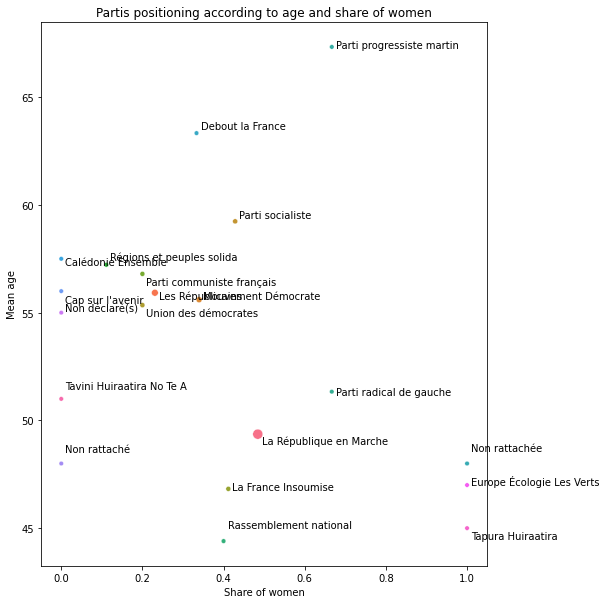

In [7]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def yearsago(years, from_date=None):
    if from_date is None:
        from_date = datetime.now()
    return from_date - relativedelta(years=years)

def num_years(begin, end=None):
    if end is None:
        end = datetime.now()
    num_years = int((end - begin).days / 365.25)
    if begin > yearsago(num_years, end):
        return num_years - 1
    else:
        return num_years

# Count the number of actors of each sex in each party
parite_table = pd.pivot_table(actors, values="membre_acteurRef", columns="membre_sex", index="membre_parti", aggfunc='count', fill_value=0).reset_index().rename({"membre_parti": "parti"}, axis=1).set_index('parti')
# Compute the share of women of each party
parite_table["parti_share_women"] = parite_table["F"] / (parite_table["F"] + parite_table["H"])
parite_table.drop(["F", "H"], axis=1, inplace=True)

# Compute age of actors
actors['membre_birthDate'] = pd.to_datetime(actors['membre_birthDate'])
actors["membre_age"] = actors["membre_birthDate"].apply(num_years)
# Compute the average age of actors of each party
age_table = actors[["membre_acteurRef", 'membre_parti', "membre_age"]].groupby("membre_parti").mean().reset_index().rename({"membre_parti": "parti", "membre_age": "parti_mean_age"}, axis=1).set_index('parti')

# Group these features together and display them
parti_features = effectif_table.join(parite_table).join(age_table)

# Plot
plt.figure(figsize=(8,10))
p1 = sns.scatterplot(x='parti_share_women', y='parti_mean_age', data=parti_features.reset_index(), size = "parti_nb_membres", hue="parti", legend=False, sizes=(20,100))  

for line in range(0, parti_features.shape[0]):
    # Jitter the text a bit to avoid text clusters
     p1.text(parti_features['parti_share_women'][line]+0.01, parti_features['parti_mean_age'][line] + 1.2*(0.5 - np.random.random()), 
     parti_features.reset_index()['parti'][line][:25], horizontalalignment='left', 
     size='medium', color='black', weight='light')

plt.title('Partis positioning according to age and share of women')
plt.xlabel('Share of women')
plt.ylabel('Mean age')

For the share of women, "Les Républicains" are way behind the other big parties by having only 25% of women, when "La République En Marche", "Parti socialiste" and "La France Insoumise" have roughly 50% of women. Parties with 100% of women have only 1 member. 

Regarding the age of the big parties, "Mouvement démocrate", "Parti socialiste" and "Les Républicains" are the oldest in the assembly. This is the traditional "left vs center vs right" paradigma. On the countrary, "La République En Marche" and "Front National", the two parties that dueled in the Presidential election last round, are younger. This corresponds to new "liberals vs nationalists" paradigma.

#### Exploring votes position repartition

Let's compare the count of "for" and "other" positions. The repartition seems roughly balanced. 

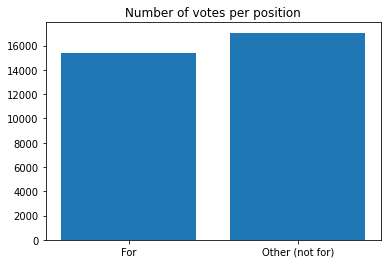

In [8]:
votes_for = y.sum()
votes_other = y.shape[0] - votes_for

plt.bar([1, 2], [votes_for.sum(), votes_other.sum()])
plt.xticks([1, 2], ('For', 'Other (not for)'))
plt.title("Number of votes per position")
plt.show()

But if we do a breakdown per group, the story is not the same. "LaRem" (La République En Marche) and "Dem" (Démocrates et apparentés) rarely vote *for*. And the Left leaning groups (SOC Socialistes, FI France Insoumise, GDR Gauche Démocrate et Républiquaine) very often vote for, despite being a minority in the Assembly. 

The intuition we get is that left-leaning groups propose a lot of amendments that the majority groups (La République En Marche and Démocrates et appartentés) systematically block. Those kind "useless amendments" (that demandeur group *know* will be blocked, but that are proposed nonetheless, just to **delay** the proposition of law), are known in US politics as [Filibuster](https://en.wikipedia.org/wiki/Filibuster) (*obstruction parlementaire* in French). In the next graph, we will confirm this intuition. 

From a machine learning point of view, this means that classes are imbalanced. Beware !

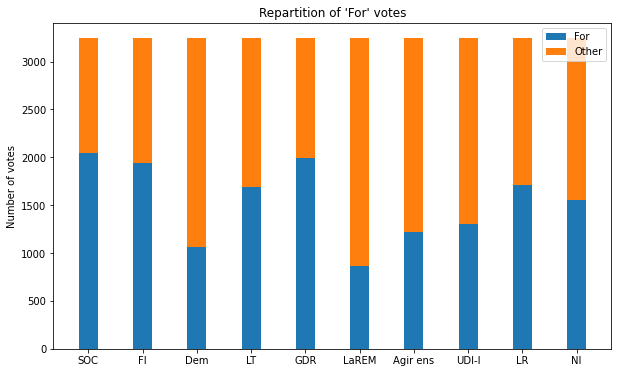

In [9]:
ind = np.arange(len(y.columns))

plt.figure(figsize=(10,6))

p1 = plt.bar(ind, votes_for, width=0.35)
p2 = plt.bar(ind, votes_other, width=0.35, bottom=votes_for)


plt.ylabel('Number of votes')
plt.title('Repartition of \'For\' votes')
plt.xticks(ind, y.columns)
plt.legend((p1[0], p2[0]), ("For", 'Other'))

plt.show()

#### Vote demandeur repartition

Let's now look at the most common demandeur. We recall that the **demandeur** is the group that asks for an amendment. 

To clean up demandeur's column, we use a custom Transformer available in `estimator.py`.

We see that the group La France Insoumise, despite having 17 deputies in the Assemblée, is the leading demandeur. This means that most amendments are proposed by this minority group. This confirm our previous analysis of fillibusting. Depending on your point of view, you can say that :
- France Insoumise defends democracy by preventing bad laws from being voted, and asking for radical changes.
- France Insoumise asks for useless votes that will be, most of the time, discarded, just to slow down laws' adoptions. 

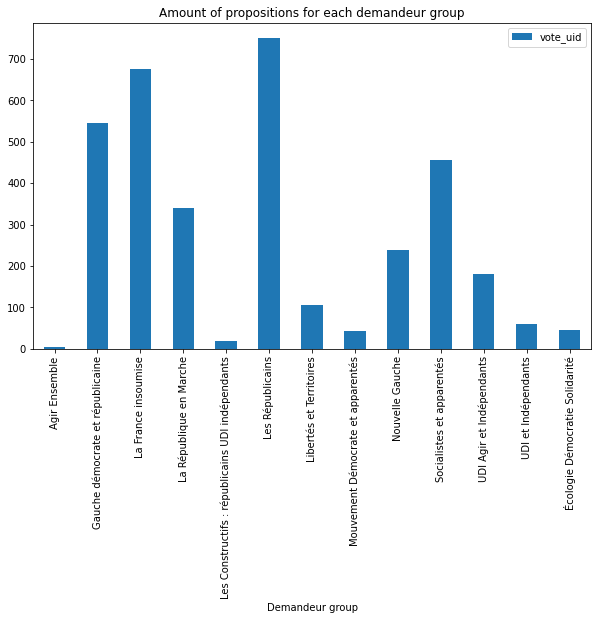

In [10]:
from estimator import FindGroupVoteDemandeurTransformer
from ast import literal_eval

demandeur = FindGroupVoteDemandeurTransformer()
X_b = demandeur.transform(X.copy())
# Won't explode without this trick
X_b['demandeur_group'] = X_b['demandeur_group'].apply(literal_eval)
X_b = X_b[["demandeur_group", "vote_uid"]].explode('demandeur_group', ignore_index=True)
demandeur_table = X_b.groupby("demandeur_group").count()

# Plot
demandeur_table.plot(kind='bar', figsize=(10,6))
plt.title("Amount of propositions for each demandeur group")
plt.xticks(rotation=90)
plt.xlabel("Demandeur group")
plt.show()

Now, let's cross this information with the voting groups, to see which group vote most for which group's propositions. To do that, we compute some kind of confusion matrix that indicates the share of times a voting group voted for this demandeur group. 

In [11]:
map_group_sigle = {'Agir Ensemble': 'Agir ens', 
'Gauche démocrate et républicaine': 'GDR',
'La France insoumise': 'FI',
'La République en Marche': 'LaREM',
'Les Républicains': 'LR',
'Libertés et Territoires': 'LT',
'Socialistes et apparentés': 'SOC',
'UDI Agir et Indépendants': 'UDI Agir I',
'UDI et Indépendants': 'UDI-I',
'Écologie Démocratie Solidarité': 'Eco',
'Non inscrits': 'NI',
'Nouvelle Gauche': 'NG',
"Les Constructifs : républicains UDI indépendants": "LC",
"Mouvement Démocrate et apparentés": "Dem",
np.nan: 'UNK'}

X_b['demandeur_group_sigle'] = X_b['demandeur_group'].apply(lambda x: map_group_sigle[x])

partisanship_table = X_b.set_index('vote_uid').join(y).groupby('demandeur_group_sigle').sum()
opposition_table =  X_b.set_index('vote_uid').join(1 - y).groupby('demandeur_group_sigle').sum()

# Normalize by the number of votes
partisanship_table_norm = partisanship_table / (partisanship_table + opposition_table)
partisanship_table_norm.sort_index(axis=1, inplace=True)

partisanship_table_norm

,Agir ens,Dem,FI,GDR,LR,LT,LaREM,NI,SOC,UDI-I
demandeur_group_sigle,,,,,,,,,,
Agir ens,0.800000,0.400000,0.200000,0.600000,0.600000,0.600000,0.200000,0.800000,0.200000,0.600000
Dem,0.534884,0.976744,0.488372,0.488372,0.744186,0.604651,0.441860,0.581395,0.697674,0.697674
Eco,0.244444,0.111111,0.822222,0.800000,0.377778,0.733333,0.066667,0.955556,0.711111,0.200000
FI,0.213650,0.215134,0.821958,0.707715,0.265579,0.369436,0.182493,0.298220,0.584570,0.213650
GDR,0.310662,0.255515,0.757353,0.783088,0.393382,0.534926,0.233456,0.426471,0.748162,0.321691
LC,0.666667,0.500000,0.500000,0.500000,0.833333,0.555556,0.277778,0.388889,0.555556,0.777778
LR,0.353805,0.261682,0.377837,0.455274,0.837116,0.463284,0.189586,0.576769,0.477971,0.491322
LT,0.401869,0.476636,0.514019,0.598131,0.598131,0.822430,0.242991,0.616822,0.570093,0.532710
LaREM,0.784661,0.843658,0.286136,0.336283,0.533923,0.587021,0.852507,0.687316,0.471976,0.563422


Since numbers between 0 and 1 are hard to read, we plot the results below. 
- Blue square means bottom group agrees with left group. 
- Red square means bottom group disagrees or ignores left group.  

Note here that we have some missing data, labeled UNK. The feature extraction can probably still be perfected. We guess that those might be propositions coming directly from the _Government_ or from _Ministers_.

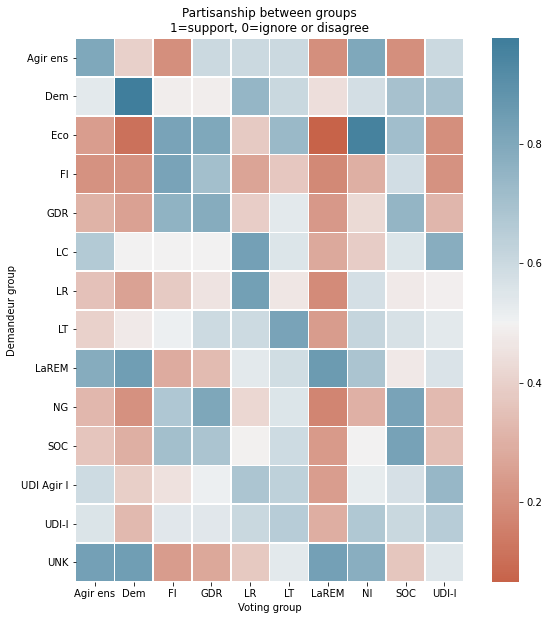

In [12]:
cmap = sns.diverging_palette(20, 230, as_cmap=True)

plt.figure(figsize=(10,10))
sns.heatmap(partisanship_table_norm.sort_index(axis=1), cmap=cmap, center=0.5, square=True, linewidths=.5,)
plt.ylabel('Demandeur group')
plt.xlabel('Voting group')
plt.title('Partisanship between groups\n1=support, 0=ignore or disagree')
# plt.xticks(rotation=60)
plt.show()

Now, the story is pretty clear. LaREM (La République En Marche) only agrees with proposals from their own members. 

In general, if the voting and the demandeur groups are the same, there is support. This is logical: groups vote for their own amendments. Let's inspect where  intra-group support is low. This is the case for FI (France Insoumise) and UDI-I (UDI Indépendants). It might be the sign of idelogical tensions inside the group. France insoumise, because of an intern crisis. UDI, by nature of the Centrist ideology. 

LaREM is often criticized for becomming more and more right-leaning on the political spectrum, since Macron appointed as ministers many politicians from LR. But, on this chart, we see that LaREM (center right) and LR (traditional right) agree mostly only on voting against FI, GDR, and SOC proposals. The support, is less clear. LR supports LaREM on a bit over half of theirs proposals, and LaREM support less than half of LR proposals. What seems to be an alliance from the outside, is much less so inside the Assembly. 

This chart also reveals ideological contradictions between public relations and votes. Notably, LaREM rarely votes for Eco (Ecologistes), despite environment being one of the main campaign points of Emmanuel Macron. 

The proposals from UDI Agir-I (UDI Agir et Indépendants) are notably cleaving. It's probably an outlier, and values are extreme due to small number of votes involving this group.  

To sum up, our statistical analysis and this chart **reveals lots of complex partisan and ideological tensions**. Will the machine learning model be able to pick up on them ?

## Sample estimator

Using NLP, we extract features from X, and create a basic fully-connected neural network to fit a classifier. 

### Feature extraction

The first step is to extract features from X. We created several custom Transformers that mostly use regex. 

1. `FindGroupVoteDemandeurTransformer` on the column demandeur (ex: Le Président du groupe "La France Insoumise" M. Mélenchon) to find demandeur's group (La France Insoumise). 
2. `DecomposeVoteObjetTransformer` on the column libelle, to find:
    - libelle_type: the string with the type of vote (ex: l'amendement, le sous-amendement, l'article...)
    - libelle_desc: the string with a description of the object vote (ex: loi bioéthique)
    - libelle_auteur: the list of actors mentioned in the libelle (ex: M. Melenchon). These auteurs can be different from demandeurs. 
3. `FindPartyActorTransformer` on the column libelle_auteur to find the corresponding party (ex: Rassemblement National). 

This way, we extracted meaningful data from unstructured text data. This should give a upstart to our model. 

### Numerical encoding

Now, we need to encode data numerically.

- `demandeur_group` is a list of strings, each string being a category. We One Hot encode it : to each category corresponds a column, and if the category is present in the list we write 1, else 0. 
- `auteur_parti` is pretty much the same as `demandeur_group`.
- `libelle_type` is a category. We One Hot encode it.
- `libelle_desc` is a text. We encode it using TF-IDF, [which is a very classic way to encode text](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). But you could imagine something else.  
- `presence_per_party` is a dictionary. We create one column for each party with corresponding attendance. 

We then normalize each dimension between 0 and 1.  

### Neural Network model

Using Keras, we create a fully connected network with 64 hidden relu-activated Dense units and a dropout of 20%. As an output, we use 10 sigmoid activated units, one for each party. 

We take care of class imbalance by assigning weights to classes according to their observed frequency.  

In [13]:
from estimator import get_estimator

model = get_estimator()

model.fit(X_train, y_train)


Pipeline(steps=[('find_group_vote_demandeur',
                 FindGroupVoteDemandeurTransformer()),
                ('decompose_vote_object', DecomposeVoteObjetTransformer()),
                ('find_party_actor',
                 FindPartyActorTransformer(actors=     Unnamed: 0 membre_acteurRef membre_civ membre_prenom  \
0             0         PA719108         M.       Raphaël   
1             0         PA719044        Mme         Nadia   
2             0            PA672         M.  Jean-Jacques   
3             0         PA719294        Mme      Mireille   
4             0         PA719890        Mme      Danielle   
..          ...              ......
                                                  FunctionTransformer(func=<function get_estimator.<locals>.encode_party_presence at 0x7f5fabe56ef0>),
                                                  ['presence_per_party']),
                                                 ('tfidfvectorizer',
                                       

In [14]:
y_pred = model.predict(X_test)

Instructions for updating:
Please use `model.predict()` instead.


We compare the model accuracies for each class, independently. 

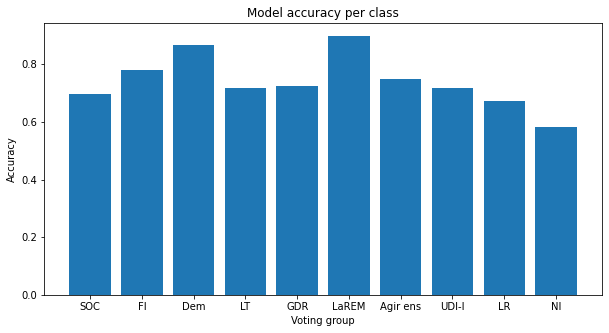

In [15]:
# Naive prediction accuracy per class

ind = np.arange(len(y_columns))

accuracies = np.mean(y_pred == y_test, axis=0)

plt.figure(figsize=(10,5))
plt.bar(ind, accuracies)

plt.ylabel('Accuracy')
plt.xlabel('Voting group')
plt.title("Model accuracy per class")
plt.xticks(ind, y.columns)
plt.show()

We however, won't be evaluating our model using accuracy, but using a custom metric defined below. 

### Evaluation

For evaluation, we use a custom metric, which is a weighted F1-score. 
- F1-score is generally the go-to when we talk of classification, since it encompasses very well two important metrics : precision and recall. 
- We don't have as many positive and negative examples inside of each class (data imbalance). F1-score is a fairer metrics than accuracy, that favours models that always yield the same value. 

Let's first compare accuracy with F1-score. 

In [16]:
from problem import CustomF1Score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Let's compute the individual F1 of each class
class_f1_scores = []
for i in range(10):
    class_f1_scores.append(f1_score(y_test[:,i], y_pred[:,i]))

f1_df = pd.DataFrame(class_f1_scores, y.columns, columns=["F1 score"]).transpose()
f1_df

,SOC,FI,Dem,LT,GDR,LaREM,Agir ens,UDI-I,LR,NI
F1 score,0.766667,0.824691,0.779747,0.719755,0.784504,0.80814,0.641758,0.619543,0.652459,0.615385


On this graph, you see how F1-score is a bit more pessimistic about LREM, that has lots of negative examples. Probably our model outputs lots of zeros, without much thinking. F1-score helps us alleviate this bias, and see the model's performances more realistically. 

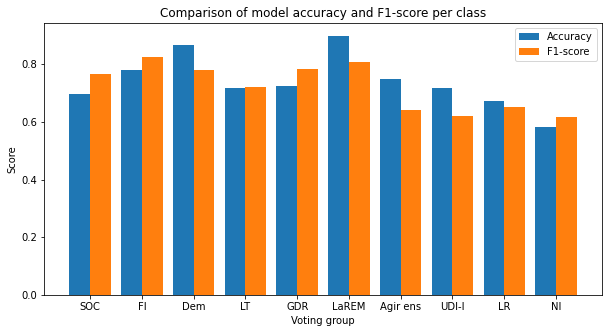

In [17]:
plt.figure(figsize=(10,5))

plt.bar(ind-0.2, accuracies, width=0.4)
plt.bar(ind+0.2, class_f1_scores, width=0.4)

plt.ylabel('Score')
plt.xlabel('Voting group')
plt.title("Comparison of model accuracy and F1-score per class")
plt.xticks(ind, y.columns)
plt.legend(["Accuracy", "F1-score"])
plt.show()

Now, about our custom metric. 

For each of the 10 class, we compute an F1-score, and then average all of those. The weights are the log-proportions of the share of deputies of this group. 

$$\forall g^* \in \text{Groups}, \text{weight}_{g^*} = \frac{\log (\text{# deputies in group } g^*)} {\sum_{g \in \text{Groups}} \log (\text{# deputies in group } g)}$$

$$F1_{log-weighted} = \sum_{g \in \text{Groups}} \text{weight}_g \times F1(\text{class } g)$$

This way :
- We focus more on big groups (in Democracy, majority groups are the ones that matter)
- Using the log-proportion, smaller groups are not discarded (we won't evaluate the model only on its performances with LREM). 

A good score is close to 1, a bad score is close to 0. 

Below, we compare $F1_{\text{non-weighted}}$, $F1_{\text{linear-weighted}}$ (same formulas as above but without the logarithms), and $F1_{\text{log-weighted}}$ that we just presented. 

In [18]:
# Basic average
non_weighted_score = np.mean(class_f1_scores)

# Linear weights average 
linear_score = CustomF1Score(weights_type="linear")(y_test, y_pred)

# Log weights average : the metric that will be used in the RAMP challenge. 
log_score = CustomF1Score(weights_type="log")(y_test, y_pred)


print(f"Non-weighted average of F1 scores: {non_weighted_score:.3f}")
print(f"Linear-weighted average of F1 scores: {linear_score:.3f}")
print(f"Log-weighted average of F1 scores: {log_score:.3f}")

Non-weighted average of F1 scores: 0.721
Linear-weighted average of F1 scores: 0.752
Log-weighted average of F1 scores: 0.725


We see that Log-weighted is more optimistic on the performance of our model than non-weighted F1, while still being more pessimistic than linear-weighted F1. This is kind of a compromise between the two. 

On the graph below, we compare the scoring weights. 

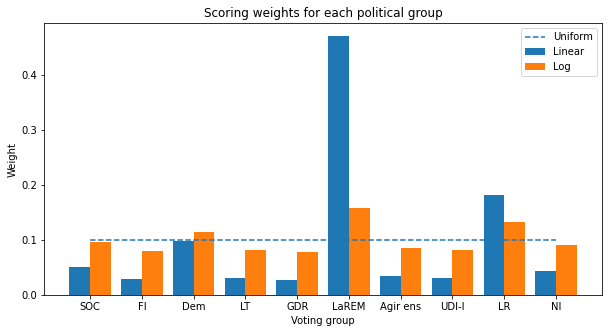

In [19]:
plt.figure(figsize=(10,5))
plt.bar(ind-0.2, CustomF1Score(weights_type="linear").weights_, width=0.4)
plt.bar(ind+0.2, CustomF1Score(weights_type="log").weights_, width=0.4)
plt.plot(ind, .1*np.ones(ind.shape[0]), "--")

plt.ylabel('Weight')
plt.xlabel('Voting group')
plt.title("Scoring weights for each political group")
plt.xticks(ind, y.columns)
plt.legend(['Uniform', 'Linear', 'Log'])
plt.show()

## Conclusion 

We found that the voting position of political groups is, to an extent, predictible. 

Rivalry between political groups is the main driver of their votes. When a political group votes, it doesn't try to chose the best option for the nation, as it reaffirms its position : its ideology, its support of a group, its opposition to another group. 

Paradoxically, we can say that this is reassuring for us, citizens. This means that :
- Deputies don't vote randomly, which is always good to know. 
- Deputies defend the positions they have been elected for.
- Rivalry in the National Assembly means that there is a political debate, and this is what democracy is all about.

We conclude this study of National Assembly with a broader understanding of forces driving votes in the National Assembly. 